In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import graphviz
import torch_geometric
from torch_geometric.data import Dataset, Data, InMemoryDataset
from SALBP_solve import *
import os.path as osp
import ast
from sklearn.preprocessing import MinMaxScaler
import torchmetrics
import sys
import os
from datetime import datetime

sys.path.append(os.path.abspath("torch"))
from salb_dataset import *
from gnns import *
from torch.utils.tensorboard import SummaryWriter

In [2]:
! ls ../../

DADA  gurobi.log  julia_toml  MMABPW  nearline	projects  scratch  work


In [3]:



my_dataset = SALBDataset(root='pytorch_datasets/medium',edge_data_csv ="medium_res_data_good_rows.csv",  alb_filepath=os.path.normpath("../../MMABPW/SALBP_benchmark/medium data set_n=50/"), raw_data_folder ="pytorch_datasets/medium/raw/")


In [4]:
my_dataset[22]

Data(x=[50, 1], edge_index=[2, 51], instance='instance_n=50_12', precendence_relation=[51], edge_classes=[51], graph_class=False, n_stations=[51])

In [5]:
#! rm -r pytorch_datasets/medium/processed/

In [6]:
my_dataset[3]

Data(x=[50, 1], edge_index=[2, 68], instance='instance_n=50_102', precendence_relation=[68], edge_classes=[68], graph_class=True, n_stations=[68])

In [7]:
print(my_dataset[0].x)

tensor([[0.0950],
        [0.1910],
        [0.1650],
        [0.1020],
        [0.0740],
        [0.1670],
        [0.1020],
        [0.1630],
        [0.2360],
        [0.2210],
        [0.1020],
        [0.0460],
        [0.0270],
        [0.1200],
        [0.0900],
        [0.3060],
        [0.0410],
        [0.0630],
        [0.0810],
        [0.1800],
        [0.2530],
        [0.0960],
        [0.1020],
        [0.2380],
        [0.1270],
        [0.1840],
        [0.1020],
        [0.1090],
        [0.0960],
        [0.1280],
        [0.1890],
        [0.0970],
        [0.2850],
        [0.0280],
        [0.1650],
        [0.1820],
        [0.2020],
        [0.0840],
        [0.0230],
        [0.1530],
        [0.0780],
        [0.1120],
        [0.0530],
        [0.1130],
        [0.1890],
        [0.0820],
        [0.2210],
        [0.0510],
        [0.0900],
        [0.2370]])


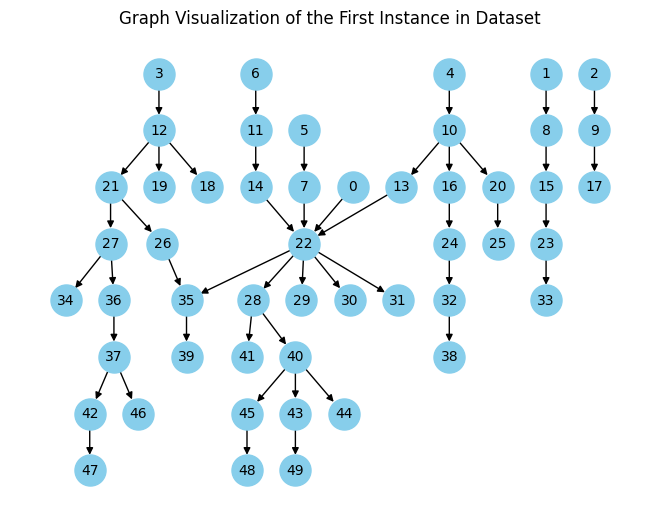

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the first graph in my_dataset is at index 0
data = my_dataset[0]
def plot_pytorch_graph(data):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    graph = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    #adds nodes
    for j in range(data.x.shape[1]):
        graph.add_node(j)
    #adds edges
    for i in range(edge_index.shape[1]):
        graph.add_edge(edge_index[0, i], edge_index[1, i])

    pos = nx.nx_pydot.graphviz_layout(graph, prog = "dot")

    # Draw the graph, changes graph to graphviz and uses
    nx.draw(graph, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", pos=pos)

    plt.title("Graph Visualization of the First Instance in Dataset")
    plt.show()
plot_pytorch_graph(data)

In [9]:


# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
# from torch_geometric.loader import DataLoader
# import torch.nn as nn
# from torch_geometric.nn import global_mean_pool
# from torch.utils.data import random_split

# class EdgeClassifier(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, edge_dim=None):
#         super(EdgeClassifier, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
#         # For edge features (if available)
#         edge_input_dim = 2 * hidden_channels
# #         if edge_dim is not None:
# #             edge_input_dim += edge_dim
            
#         self.edge_mlp = torch.nn.Sequential(
#             torch.nn.Linear(edge_input_dim, hidden_channels),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_channels, out_channels)
#         )
        
#     def forward(self, x, edge_index, edge_attr=None):
#         # Node embedding
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
        
#         # Edge embedding - gather node features for each edge
#         parents, children = edge_index
#         edge_features = torch.cat([x[parents], x[children]], dim=1)
        
#         # # Combine with edge attributes if available
#         # if edge_attr is not None:
#         #     edge_features = torch.cat([edge_features, edge_attr], dim=1)
            
#         # Edge classification
#         return self.edge_mlp(edge_features)

In [10]:
# Get global statistics across all graphs
# def get_edge_label_stats(dataset):
#     all_labels = []
#     for data in dataset:
#         all_labels+=data.edge_classes
    
#     torch_labels = torch.tensor(all_labels, dtype=torch.bool)
#     counts = torch.bincount(torch_labels.int())
#     return counts

# # Calculate class weights
# class_counts= get_edge_label_stats(my_dataset)
# total_edges = class_counts.sum()
# class_weights = total_edges / (2 * class_counts)
# class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)

# Count total positive and negative edges across all graphs
def get_pos_weight(data_list):
    num_pos = sum(data.edge_classes.sum().item() for data in data_list)
    num_neg = sum(len(data.edge_classes) - data.edge_classes.sum().item() for data in data_list)

    # Compute pos_weight for BCEWithLogitsLoss
    pos_weight = torch.tensor([num_neg / num_pos])  # Shape: (1,)
    return pos_weight
pos_weight = get_pos_weight(my_dataset)
#n_neg

In [11]:
from torch_geometric.loader import DataLoader


In [12]:

# Hyperparameters
in_channels = 1 # Assuming a single feature per node.
hidden_channels = 64
out_channels = 1 # Number of classes for your classification task.
learning_rate = 0.01
epochs = 10000
batch_size = 5#TODO: Make it work for larger batch sizes
#splits the data into train and test
input_dataset = my_dataset.copy()
train_dataset, test_dataset = random_split(input_dataset, [int(len(input_dataset)*0.8), len(input_dataset) - int(len(input_dataset)*0.8)])
# train_dataset = [input_dataset[3]]
# test_dataset = [input_dataset[3]]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

accuracy = torchmetrics.Accuracy(task="binary")
precision = torchmetrics.Precision(task="binary")
recall = torchmetrics.Recall(task="binary")
f1_score = torchmetrics.F1Score(task="binary")

writer = SummaryWriter('runs/experiment_name')
# Get today's date as a string
today_str = datetime.today().strftime('%Y-%m-%d')

# Use it in a filename
filename = f"training_log_{today_str}.txt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)
model = EdgeClassifier(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#loss_fn = torch.nn.BCEWithLogitsLoss()

criterion = nn.BCEWithLogitsLoss()
# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    # total_correct = 0
    # total = 0
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out.T, data.edge_classes.unsqueeze(dim=0).float())
        # probs = torch.sigmoid(out)
        # preds = (probs > 0.5).int().squeeze(1)
        # total_correct += (preds == data.edge_classes)
        # total += len(preds)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    
      
    writer.add_scalar('Loss/train', total_loss, epoch)
    # acc = toal_correct/total
    #writer.add_scalar('Accuracy/train', acc, epoch)
    # writer.add_scalar('Recall/train', rec, epoch)
    # writer.add_scalar('Precision/train', prec, epoch)

    
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    # Evaluation
    model.eval()
    #  Testing loop
    with torch.no_grad():
      total_loss = 0
      for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)
        loss = loss_fn(out.T, data.edge_classes.unsqueeze(dim=0).float())
        probs = torch.sigmoid(out)
        print("average probability", probs.squeeze(1).float().mean())
        # Set a threshold to convert probabilities to binary predictions
        threshold = 0.5
        targets = data.edge_classes
        preds = (probs > 0.5).int().squeeze(1)
        acc = accuracy(preds, targets)
        prec = precision(preds, targets)
        rec = recall(preds, targets)
        f1 = f1_score(preds, targets)
        writer.add_scalar('Accuracy/test', acc, epoch)
        writer.add_scalar('Recall/test', rec, epoch)
        writer.add_scalar('Precision/test', prec, epoch)
        writer.add_scalar('F1/test', prec, epoch)
        writer.add_scalar('Loss/test', loss.item(), epoch)

        #correct = (predictions.squeeze(1) == data.edge_classes)  # Per-class correct predictions
        # print(correct)
        
        
        # Overall accuracy
        #overall_accuracy = (predictions.squeeze(1) == data.edge_classes).float().mean()

        # Print metrics

        #print(f"Correct: {correct.tolist()}")
        #print(f"Overall accuracy: {overall_accuracy.item()}")
        
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")


using device: cpu
Epoch 1, Loss: 1.457309171335021
average probability tensor(0.3746)
Accuracy: 0.9777, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3835)
Accuracy: 0.9413, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3739)
Accuracy: 0.9748, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3893)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3825)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3779)
Accuracy: 0.9898, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3821)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3820)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3715)
Accuracy: 0.9934, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
aver


KeyboardInterrupt



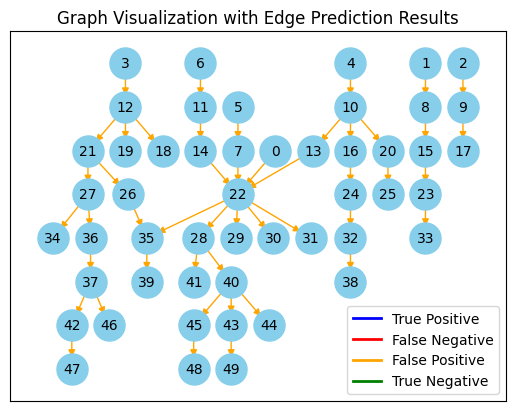

In [13]:
def plot_edge_prediction_graph(data, model, threshold=0.5):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = torch.sigmoid(out)
        preds = (probs > threshold).int().squeeze()
    
    # Get the edge targets
    targets = data.edge_classes
    
    graph = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    
    # Add nodes
    for j in range(data.x.shape[0]):  # Changed from data.x.shape[1] to data.x.shape[0] for number of nodes
        graph.add_node(j)
    
    # Create lists for edges and colors
    edges = []
    edge_colors = []
    
    # Add edges with appropriate colors based on prediction results
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        edges.append((src, dst))
        
        # Determine color based on true/false positive/negative
        target = targets[i].item()
        prediction = preds[i].item()
        
        if target == 1 and prediction == 1:
            # True Positive - Blue
            color = 'blue'
        elif target == 1 and prediction == 0:
            # False Negative - Red
            color = 'red'
        elif target == 0 and prediction == 1:
            # False Positive - Orange
            color = 'orange'
        else:  # target == 0 and prediction == 0
            # True Negative - Green
            color = 'green'
            
        edge_colors.append(color)
        graph.add_edge(src, dst)
    
    # Position the nodes
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    
    # Draw the graph with colored edges
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color="skyblue")
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black")
    nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=edge_colors, arrows=True)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='True Positive'),
        Line2D([0], [0], color='red', lw=2, label='False Negative'),
        Line2D([0], [0], color='orange', lw=2, label='False Positive'),
        Line2D([0], [0], color='green', lw=2, label='True Negative')
    ]
    plt.legend(handles=legend_elements)
    
    plt.title("Graph Visualization with Edge Prediction Results")
    plt.show()
    
data = my_dataset[0]
plot_edge_prediction_graph(data, model)

In [ ]:
!which python